# Aim

Inverse detection efficiency completeness calculation on TESS data. Currently only uses geometric probabilities.

IDEM as in Appendix A of Hsu 2018 (https://arxiv.org/pdf/1803.10787.pdf).

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from tqdm.notebook import tqdm
from os import path
from dev import utils

%load_ext autoreload
%autoreload 2

In [2]:
stellar = utils.get_tess_stellar().drop_duplicates("ID")
print("Initial number of targets: {}".format(len(stellar)))
stellar = stellar[np.isfinite(stellar['rad'])]
stellar = stellar[np.isfinite(stellar['mass'])]
print("Cut to {} targets".format(len(stellar)))

Initial number of targets: 244730
Cut to 189744 targets


In [3]:
planetary = utils.get_tois()
print("Initial number of TOIs: {}".format(len(planetary)))
planetary = planetary[np.isfinite(planetary['Planet Radius Value'])]
planetary = planetary[np.isfinite(planetary['Orbital Period Value'])]
print("Cut to {} TOIs".format(len(planetary)))

Initial number of TOIs: 2098
Cut to 1917 TOIs


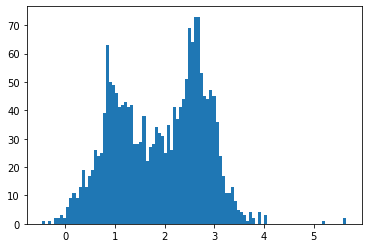

In [4]:
# let's group all these planets into buckets based on planet size and orbital period!
radii = np.array(planetary['Planet Radius Value'])
_ = plt.hist(np.log(radii), bins=100)

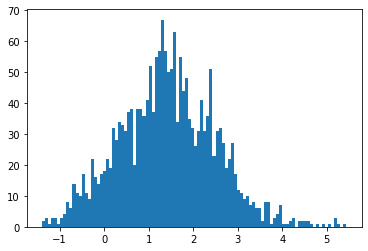

In [5]:
periods = np.array(planetary['Orbital Period Value'])
_ = plt.hist(np.log(periods), bins=100)

In [6]:
long_planets = planetary[planetary["Orbital Period Value"] > 27.4]
for planet in long_planets.iterrows():
    planet = planet[1]
    if planet["Orbital Period Value"] > 27.4 * len(planet["Sectors"]):
        print("TOI {0} has a period of {1} days and was observed in {2} sectors.".format(planet["Full TOI ID"], planet["Orbital Period Value"], len(planet["Sectors"])))
        print("Public comment on this TOI: {}".format(planet["Public Comment"]))

TOI 1823.01 has a period of 194.05 days and was observed in 5 sectors.
Public comment on this TOI: Two transits separated by 194d. Possible periods: 194d 97d 64.7d 48.5 or 38.8. Slight depth-aperture and match to two nearby stars.
TOI 1859.01 has a period of 63.48434 days and was observed in 2 sectors.
Public comment on this TOI: period could be 3x
TOI 916.01 has a period of 29.17362 days and was observed in 1 sectors.
Public comment on this TOI: slightly off target; hint of an odd-even difference.
TOI 933.01 has a period of 88.93384 days and was observed in 2 sectors.
Public comment on this TOI: Period is twice as long (89 days) and planet is ~2x smaller
TOI 2074.01 has a period of 177.583051 days and was observed in 5 sectors.
Public comment on this TOI: potential L1 candidate; only 2 transits so period not well constrained; no additional sectors for this target


Text(0, 0.5, 'Log-radius (ln Earth radii)')

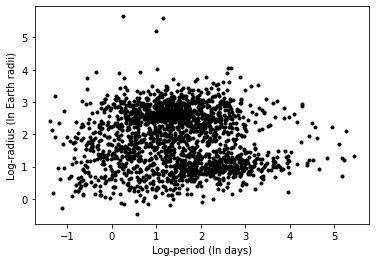

In [7]:
plt.plot(np.log(periods), np.log(radii), ".k")
plt.xlabel("Log-period (ln days)")
plt.ylabel("Log-radius (ln Earth radii)")

In [8]:
# planetary = planetary[planetary['TOI Disposition'] == "PC"]
combined = pd.merge(planetary, stellar, left_on="TIC", right_on="ID")
periods = combined['Orbital Period Value'].values
prads = combined['Planet Radius Value'].values
len(combined)

1136

In [9]:
def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    # dfm.io/posts/exopop
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

pgeoms = combined['rad'].values / get_a(periods, combined['mass'].values)

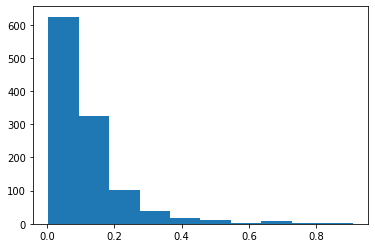

In [10]:
_ = plt.hist(pgeoms)

In [11]:
def pcomp(period, rstars=stellar['rad'].values, mstars=stellar['mass'].values):
    '''
    For each of the stars in the stellar catalog, computes the probability of detection 
    of the planet with the given period and radius 
    
    Arguments
    ---------
    stellar : pd.DataFrame
    The full stellar catalog, as extracted from the merge on MAST and the MIT TEV database.
    
    period : scalar
    The period value for the TOI, in days.
    
    prad : scalar
    The radius value for the TOI, in R_Earths.

    Returns
    -------
    pcomps : np.ndarray
    The probability of each of the detections.
    '''
    pgeoms = rstars / get_a(period, mstars)
    return pgeoms

In [12]:
if not path.exists('../data/idem_pdets.npy'):
    pdet_ij = np.empty((len(periods), len(stellar)))
    for i, period in enumerate(tqdm(periods, total=len(planetary))):
        pdet_ij[i] = pcomp(period)
    np.save('../data/idem_pdets.npy', pdet_ij)
else:
    pdet_ij = np.load('../data/idem_pdets.npy')

In [13]:
if not path.exists('../data/idem_pdets_i.npy'):
    pdet_i = np.nanmean(pdet_ij, axis=1)
    np.save('../data/idem_pdets_i.npy', pdet_i)
else:
    pdet_i = np.load('../data/idem_pdets_i.npy')

(array([377., 288., 113.,  70.,  32.,  25.,  26.,  10.,   3.,   3.]),
 array([0.00693644, 0.06926525, 0.13159406, 0.19392287, 0.25625168,
        0.31858049, 0.3809093 , 0.44323811, 0.50556692, 0.56789573,
        0.63022454]),
 <a list of 10 Patch objects>)

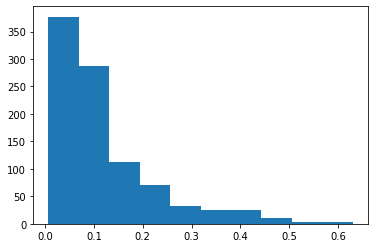

In [14]:
plt.hist(pdet_i)

In [15]:
weights = np.nan_to_num(1 / pgeoms)

In [16]:
period_bins = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp_bins = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
counts = np.histogram2d(periods, prads, bins=[period_bins, rp_bins])[0]
N = np.histogram2d(periods, prads, bins=[period_bins, rp_bins], weights=weights)
f = N[0] / len(stellar)

Text(0, 0.5, 'Period (days)')

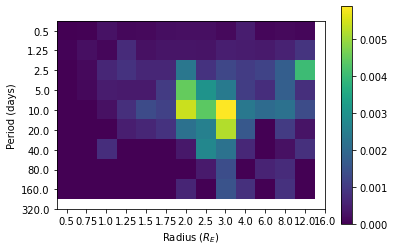

In [17]:
plt.imshow(f)
plt.colorbar()
_ = plt.xticks(list(range(len(rp_bins))), rp_bins)
plt.xlabel(r"Radius ($R_E$)")
_ = plt.yticks(list(range(len(period_bins))), period_bins)
plt.ylabel("Period (days)")

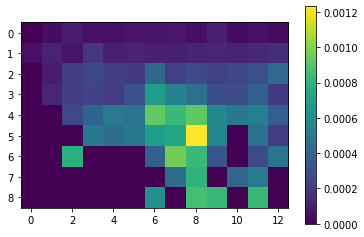

In [18]:
sigmas = np.divide(f, np.sqrt(counts), out=np.zeros_like(f), where=counts!=0)
plt.imshow(sigmas)
plt.colorbar()